In this notebook I will demonstarte how you can use barebones PyTorch to separate linearly inseparable toy **[sklearn.make_moons](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html)** and **[sklearn.make_circles](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html)** datasets.

First, let's make necessary imports:

In [30]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from catalyst import utils

sns.set(style="darkgrid", font_scale=1.4)
%config InlineBackend.figure_format = 'retina'

## Logistic Regression

Let's take a look at what happens in logistic regression. At the input we have a matrix object-attribute X and a column-vector $y$ - labels from $\{0, 1\}$ for each object. We want to find a matrix of weights $W$ and a bias $b$ that our model $XW + b$ will somehow predict the class of the object. As you can see in the output, our model can produce a number in the range from $(-\infty;\infty)$. This output is commonly referred to as "logits". We need to translate it to the interval from $[0; 1]$ in order for it to give us the probability of the object belonging to the first class, it is also better for this function to be monotonic, quickly calculated, have a derivative and on $-\infty$ have the value $0$, on $+\infty$ - $1$. This class of functions is called sigmoid. Most often we take as a sigmoid
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

I will write a PyTorch module that implements $logits = XW + b$, where $W$ and $b$ are [parameters](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (`nn.Parameter`) of the model. In other words, here I implement the [module `nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with our own hands. I will initialize weights with normal distribution (`torch.randn`).

In [31]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x = x @ self.weights # input x - multiplies input with weights
        if self.bias:
            x += self.bias_term # sum with bias_term
        return x

### Make Moons dataset

Let's initialize `make_moons` dataset:

In [32]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.07)

We can look at it in this way:

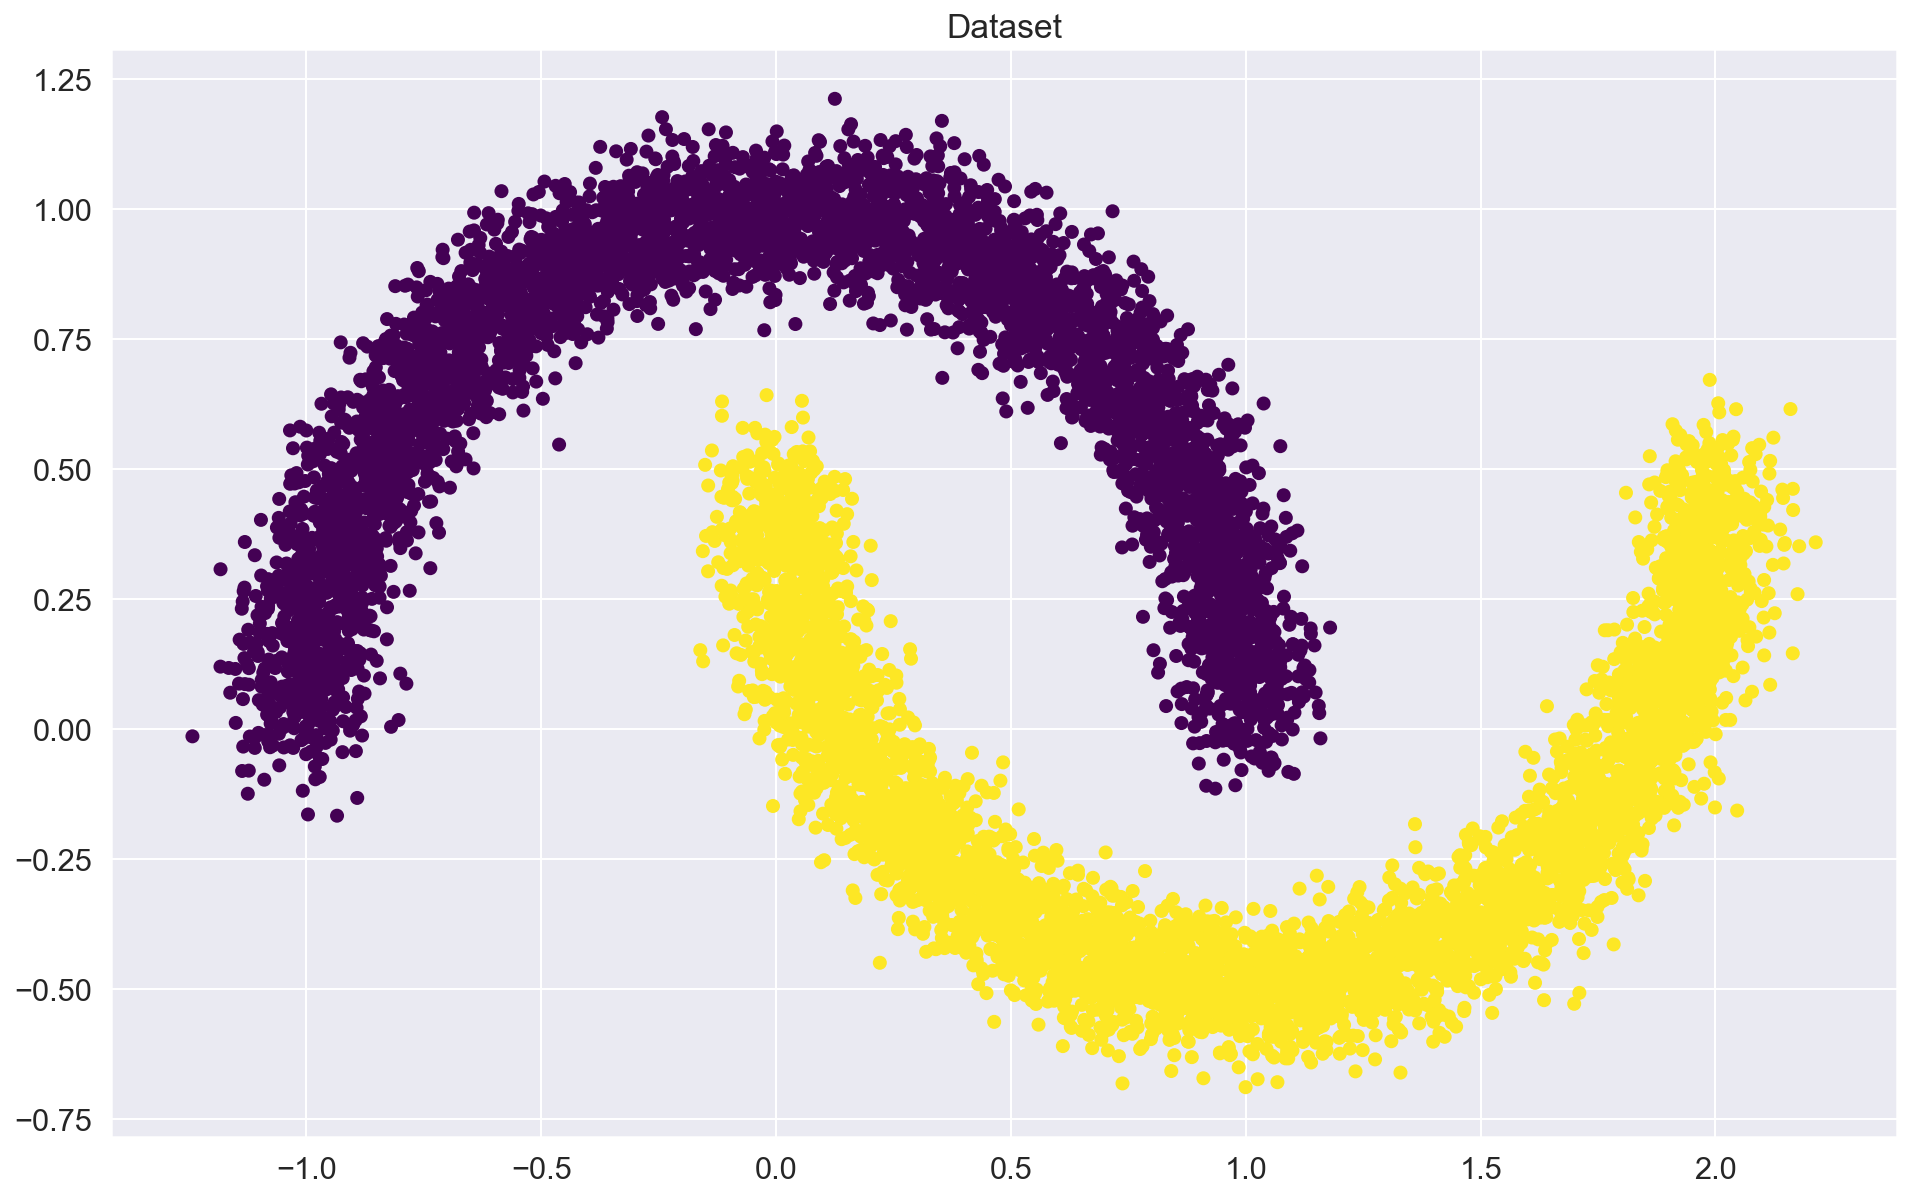

In [33]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Before we proceed we will split the dataset into **tain/validation**: **(train_test_split)**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

Convert to `torch.tensor`: 

torch.from_numpy() *numpy to tensor*

.to(torch.float32) *torch to torch.float32*

In [60]:
print(len(y_train))
print(len(y_test))

7500
2500


In [52]:
X_train = torch.from_numpy(X_train).to(torch.float32)
X_test = torch.from_numpy(X_test).to(torch.float32)
y_train = torch.from_numpy(y_train).to(torch.float32)
y_test = torch.from_numpy(y_test).to(torch.float32)

TypeError: expected np.ndarray (got Tensor)

And make `TensorDataset`'s from them:

**TensorDataset()**: create a dataset pytorch

**DataLoader()**: create batchs

In [66]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [76]:
train_dataloader = DataLoader(train_dataset, batch_size = 128, shuffle = True)

In [75]:
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle = True)

Now, as we prepared our data, we can define our model with `nn.Sequential`:

In [74]:
model = nn.Sequential(LinearRegression(2, 1))

For loss function we will use [**`nn.BCEWithLogitsLoss`**](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) - it combines a Sigmoid layer and the BCELoss (binary cross-entropy loss) in one single class. But you can use the nn.CrossEntropyLoss() with[`nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) and [`nn.Softmax()`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html?highlight=softmax#torch.nn.Softmax).

In [81]:
loss_func = nn.BCEWithLogitsLoss()

For optimizer we will use **Stochastic gradient descent** with learning rate = 0.05.

`torch.optim.SGD()`

In [82]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

### Train loop

Here is some pseudo code to help you figure out what happens during training:

```python
for epoch in range(max_epochs):  # <----------- iterate over the dataset several times
    for x_batch, y_batch in dataset:  # <------ iterate over the dataset. Since we use SGD and not GD, we take batches of a given size
        optimizer.zero_grad()  # <------------- zero out the gradients of the model
        outp = model(x_batch)  # <------------- get "logits" from the model
        loss = loss_func(outp, y_batch)  # <--- calculate "loss" for logistic regression
        loss.backward()  # <------------------- calculate gradients
        optimizer.step()  # <------------------ do a gradient descent step
        if convergence:  # <------------------- in case of convergence, exit the cycle
            break
```

Our actual training function will look like this:

In [85]:
def train(model, epochs):
    losses = []
    max_epochs = epochs
    stop_it = False
    for epoch in range(max_epochs):
        utils.set_global_seed(42 + epoch)
        for it, (X_batch, y_batch) in enumerate(train_dataloader):
            optimizer.zero_grad()
            outp = model(X_batch)
            loss = loss_func(outp.flatten(), y_batch)
            loss.backward()
            losses.append(loss.detach().flatten()[0])
            optimizer.step()
            probabilities = torch.sigmoid(outp)
            preds = (probabilities>0.5).type(torch.long)
    return model, losses

In [86]:
train(model, 15)

(Sequential(
   (0): LinearRegression()
 ),
 [tensor(1.0604),
  tensor(1.0851),
  tensor(0.9959),
  tensor(1.0807),
  tensor(1.0097),
  tensor(1.0232),
  tensor(0.9706),
  tensor(0.9544),
  tensor(0.9299),
  tensor(0.9407),
  tensor(1.0024),
  tensor(0.9360),
  tensor(0.9445),
  tensor(0.9369),
  tensor(0.9307),
  tensor(0.8907),
  tensor(0.8421),
  tensor(0.7991),
  tensor(0.8441),
  tensor(0.8072),
  tensor(0.7943),
  tensor(0.8329),
  tensor(0.8807),
  tensor(0.7690),
  tensor(0.7940),
  tensor(0.7888),
  tensor(0.8026),
  tensor(0.8164),
  tensor(0.7876),
  tensor(0.7667),
  tensor(0.7585),
  tensor(0.7590),
  tensor(0.7394),
  tensor(0.7320),
  tensor(0.7048),
  tensor(0.7257),
  tensor(0.7122),
  tensor(0.7434),
  tensor(0.7060),
  tensor(0.7017),
  tensor(0.7145),
  tensor(0.7201),
  tensor(0.6626),
  tensor(0.6817),
  tensor(0.6718),
  tensor(0.6419),
  tensor(0.6669),
  tensor(0.6563),
  tensor(0.6170),
  tensor(0.6467),
  tensor(0.6515),
  tensor(0.6355),
  tensor(0.6489),
  

### Loss

Next important step is to **plot loss function**:

In [89]:
def show_separation(model, save=False, name_to_save=""):
    sns.set(style="white")

    xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
    grid = np.c_[xx.ravel(), yy.ravel()]
    batch = torch.from_numpy(grid).type(torch.float32)
    with torch.no_grad():
        probs = torch.sigmoid(model(batch).reshape(xx.shape))
        probs = probs.numpy().reshape(xx.shape)

    f, ax = plt.subplots(figsize=(16, 10))
    ax.set_title("Decision boundary", fontsize=14)
    contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                          vmin=0, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, .25, .5, .75, 1])

    ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
               cmap="RdBu", vmin=-.2, vmax=1.2,
               edgecolor="white", linewidth=1)

    ax.set(xlabel="$X_1$", ylabel="$X_2$")
    if save:
        plt.savefig(name_to_save)
    else:
        plt.show()

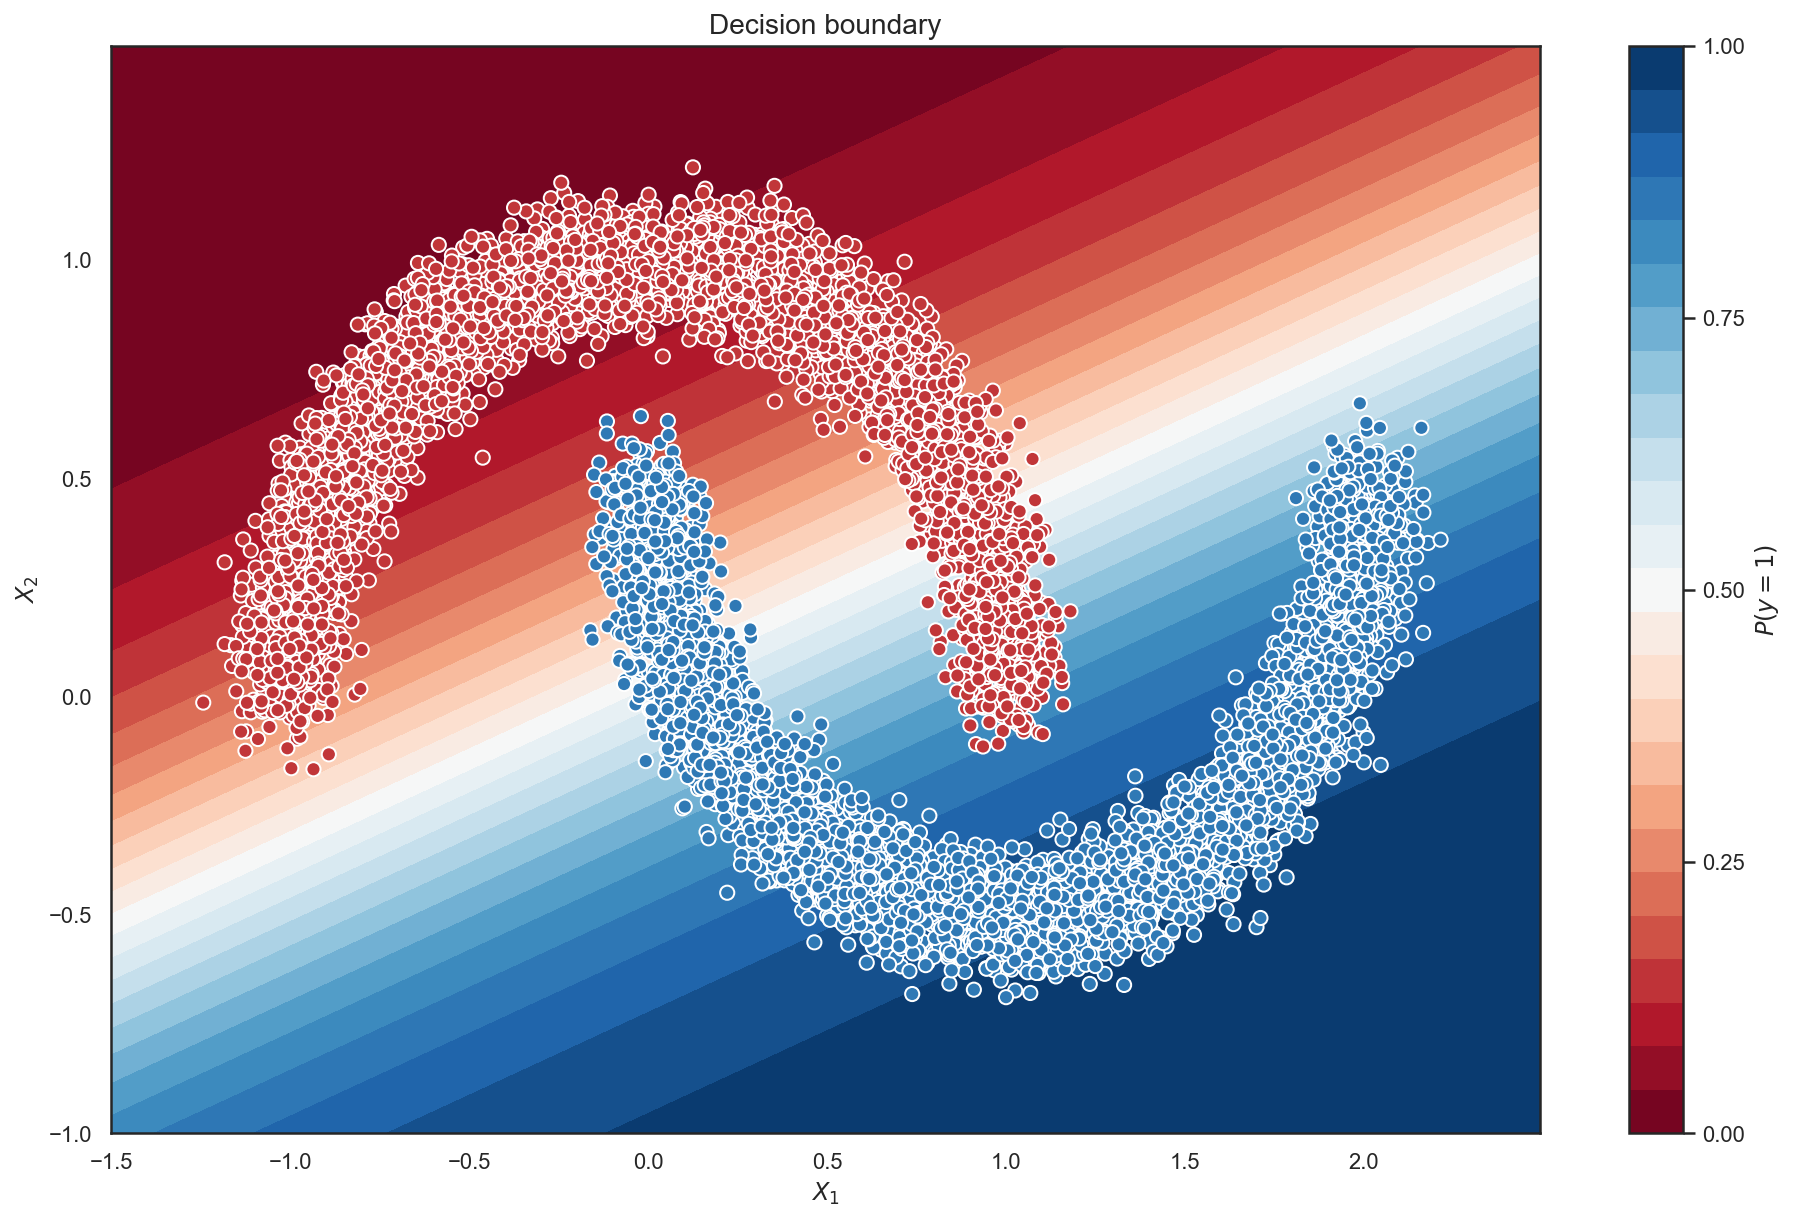

In [93]:
show_separation(model)

### Visualizing

With neat playing with matplotlib we can visualize the separation between classes in two zones: 

**Optional**

In [94]:
def plot_boundary(X,y, model, device):
    x_min, x_max = X[:,0].min()-0.1,X[:,0].max()+0.1
    y_min, y_max = y[:,0].min()-0.1,y[:,0].max()+0.1
    
    spacing = min(x_max-x_min,y_max-y_min)/100
    XX, YY = np.meshgrid(np.arange(x_min,x_max,spacing),
                         mp.arange(y_min,y_max,spacing))
    data = np.hstack((XX.ravel().reshape(-1,1),
                      YY.ravel().reshape(-1,1)))
    db_prob = model(torch.Tensor(data).to(device))
    clf     = np.armax(db_prob.cpu().data.numpy, axis = -1)
    
    Z = clf.reshape(XX.shape)
    
    plt.contourf(XX,YY,Z, cmap = plt.cm.brg, alpha = 0.5)
    plt.scatter(X[:,0],X[:,1], c = y, edgecolors = 'k', s = 25,cmap = plt.cm.brg)

In [ ]:
plot_boundary(X, y, model)

We got what we expected - **two "zones"**. Logistic regression module did the best it could. We can measure the accuracy of the model, but first we have to define `predict` function:

In [95]:
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp = model(x_batch)
        probs = torch.sigmoid(outp)
        preds = (probs > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    predictions = predictions
    return predictions.flatten()

In [97]:
predict(test_dataloader, model)

array([0., 0., 0., ..., 1., 0., 0.])

**Accuracy**

In [98]:
from sklearn.metrics import accuracy_score

### Simple Neural Network

For better result however we need something a little more complex. Again we will use `nn.Sequential` to make our model. This time it contains three `nn.Linear` layers and two activation functions. We will use the same loss function and optimizer:

Train 30 epochs and show results:

This is much better. We can see the **accuracy is almost 100%**

### Make Circles Dataset

For demonstrative purposes we can do the same for **`make_circles`** dataset

[Blog post](https://blog.neuralpony.com/2019/06/17/simple-sklearn-datasets/)